In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [3]:
def census_age_array(path = "./data/census_age.csv"):
    '''
    create array of integers that represent age distribution of US population
    array will be used to plot kernel density estimation of US population's age
    '''
    # load data and scale down count to decrease number of data points
    census_age = pd.read_csv(path)
    census_age["count"] = np.ceil(census_age["count"] / 1000).astype(int)
    
    # create empty array with length of integer total_us_population
    total_us_population = sum(census_age.loc[:, "count"])
    array = np.full(total_us_population, np.nan)
    
    # fill in array with ages
    index = 0
    for row in census_age.values:
        age, freq = row[0], row[1]
        temp = np.repeat(age, freq)
        array[index:index + freq] = temp
        index = index + freq
    
    # convert to pandas Series for use with matplotlib
    return pd.Series(array)



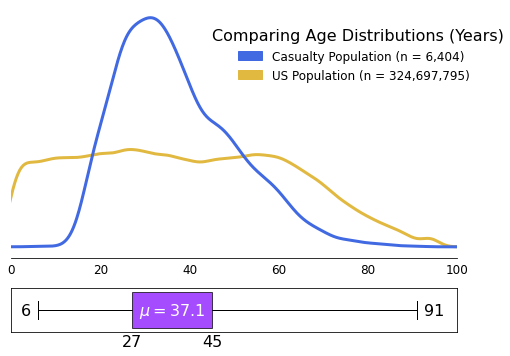

In [7]:
def compare_age_distributions(census_age, us_age_array, casuality_age_array):

    f, [ax_kde, ax_box] = plt.subplots(2, figsize = (8, 6), 
                                          sharex = True, 
                                          gridspec_kw = {"height_ratios":(0.85, 0.15)})

    ################################################
    ### EDITS TO KERNAL DENSITY ESTIMATION PLOTS ###
    ################################################

    # plot US population age distribution and cauality age distribution
    us_age_array.plot.density(ax = ax_kde, linewidth = 3, color = "#E1B941")
    casuality_age_array.plot.density(ax = ax_kde, linewidth = 3, color = "#4169E1",)

    # format x-axis of box plot
    ax_kde.set_xlabel("Years", fontsize = 14)
    ax_kde.set_xlim(0, 100)

    # format ticks of kde plot
    ax_kde.get_yaxis().set_visible(False)
    ax_kde.tick_params(axis = 'x', length = 0)

    # remove border around kde plot
    ax_kde.spines["top"].set_visible(False)
    ax_kde.spines["right"].set_visible(False)
    ax_kde.spines["left"].set_visible(False)

    #########################
    ### EDITS TO BOX PLOT ###
    #########################

    # create box plot
    bp = ax_box.boxplot(casuality_age_array.values, 
                        vert = False, 
                        showmeans = False, 
                        patch_artist = True, 
                        widths = 0.8, 
                        whis = 3)

    # color in box of boxplot
    plt.setp(bp["medians"], alpha = 0)
    for patch in bp["boxes"]:
        patch.set(facecolor = "#4169E1")

    # format ticks of box plot
    ax_box.tick_params(size = 0, labelsize = 12, pad = 12)
    ax_box.xaxis.tick_top()
    ax_box.set_yticks([])

    # remove border around box plot
    [ax_box.spines[s].set_visible(True) for s in ax_box.spines]

    # calculate minimum, lower quartile, upper quartile, and maximum of box plot
    [mi, p25, p75, ma] = np.quantile(casuality_age_array.values, [0, 0.25, 0.75, 1]).astype(int)

    # label minimum, lower quartile, upper quartile, and maximum of box plot
    ax_box.text(ma + 1.5, 1, str(ma), fontsize = 16, ha = "left", va = "center")
    ax_box.text(mi - 1.5, 1, str(mi), fontsize = 16, ha = "right", va = "center")
    ax_box.text(p25, .3, str(p25), fontsize = 16, ha = "center", va = "center")
    ax_box.text(p75, .3, str(p75), fontsize = 16, ha = "center", va = "center")

    # label mean of box plot
    x = p75 - (p75 - p25) / 2
    m = round(np.mean(casuality_age_array.values), 2)
    ax_box.text(x, 1, "$\mu = $" + str(m), fontsize = 16, ha = "center", va = "center", color = "white")

    #############################
    ### GENERAL EDITS TO PLOT ###
    #############################

    # add title
    ax_kde.text(45, .03, "Comparing Age Distributions (Years)", fontsize = 16)

    # calculate size of each popuatlation
    num_c = '{:,}'.format(len(casuality_age_array.values))
    num_us = '{:,}'.format(sum(census_age.loc[:, "count"]))

    # create legend
    casualty_patch = mpatches.Patch(color = "#4169E1", label = "Casualty Population (n = " + num_c + ")")
    us_patch = mpatches.Patch(color = "#E1B941", label = "US Population (n = " + num_us + ")")
    ax_kde.legend(handles = [casualty_patch, us_patch], 
                  prop = {"size": 12}, 
                  frameon = False, 
                  bbox_to_anchor = (.485, 0.87))

    plt.show()

census_age = pd.read_csv("./data/census_age.csv")
us_age_array = census_age_array()
casuality_age_array = pd.read_csv("./data/shooting.csv").loc[:, "age"].dropna()
compare_age_distributions(census_age, us_age_array, casuality_age_array)